In [ ]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 경로 확인
!pwd

/content


In [ ]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

/content/drive/My Drive/Colab Notebooks


## Fast R-CNN

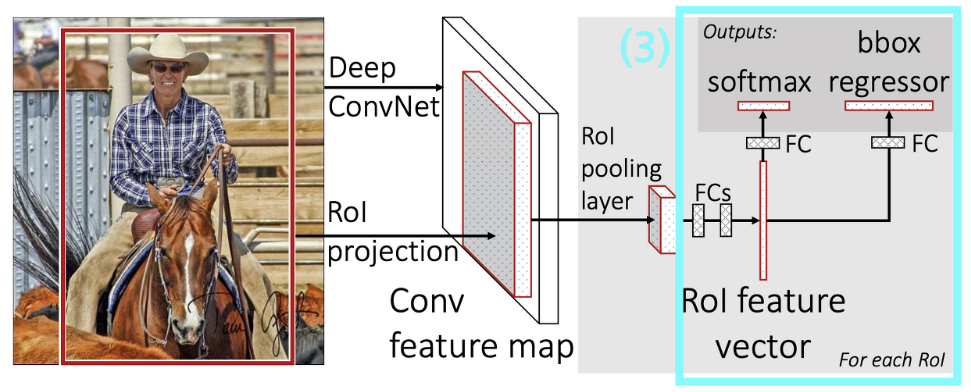

```
Fast R-CNN의 구조 

Feature Extractor -> ROI Pooling -> Classifier & Regressor


※ ROI(Region of interest): 관심 영역 
```

## Feature extractor

```
R-CNN이나 SPPNet에서 사용된것과 같이 CNN을 통해 이미지의 Feature Map을 추출하는 단계이다 
R-CNN을 떠올려보면 먼저 Selective Search를 이용해 이미지 하나 당 약 2000개의 RoI를 뽑아내고 이를 모두 CNN에 통과시켰기 때문에 엄청난 처리시간이 요구되었다
또한 추출된 RoI는 서로 겹치는 부분이 굉장히 많이 발생하기 때문에 같은 영역의 이미지가 CNN에 여러번 들어가게 되므로 비효율적이다

반면, Fast R-CNN은 Selective Search를 적용할 때 이미지를 잘라내는 것이 아니라 그 좌표와 크기정보만을  (r, c, h, w) 추출해 낸다 
이는 이미지에 비해 굉장히 적은 용량이기 때문에 다른 저장공간을 요구하지 않는다는 장점이 있다
그리고 CNN에는 이미지 한 장 만이 들어가 공통적인 Feature Map을 추출하고, 
각 RoI들은 모델을 통과하며 줄어든 크기의 비율을 따져 좌표만 변경시킨다. 이를 RoI Projection이라고 한다
```

## ROI pooling 

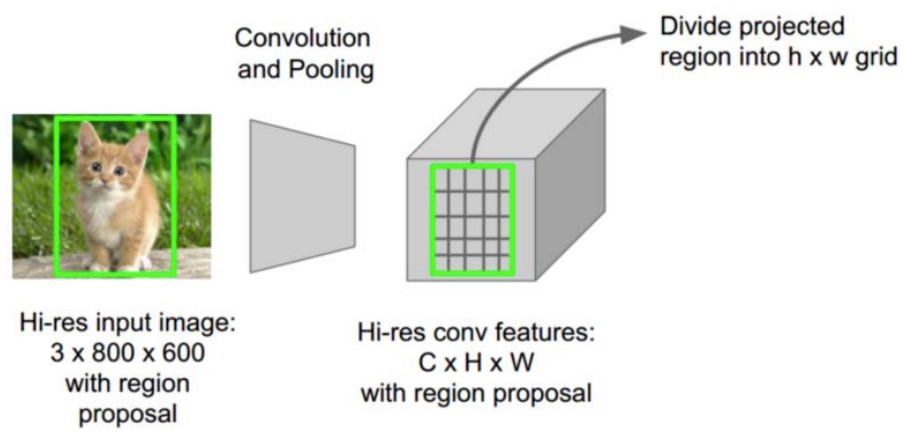

```
이미지 하나의 feature map + RoI들의좌표들을 동일한 크기로 변환하는 layer를 거친다 
이를 RoI pooling layer라고 하고 한 층짜리 spatial pyramid pooling layer와 똑같다고 생각 하면 된다. 
spatial pyramid pooling할 때 층층이 쌓인 피라미드가 누적되서 더 좋은 효과를 내지 못한다는 사실을 알게 되었기 때문에 굳이 하지 않게 되었다 
```

## Classifier & Regressor

```
Classifier는 물체가 무엇인지 구별하는 classification 역할을 하고 
Regressor는 물체의 영역을 표시하기 위한 localization 역할을 한다 
R-CNN에서는 이 둘을 따로 학습시켰지만, Fast R-CNN에서는 Multi-task loss function을 고안해서 End-to-end로 학습이 가능해 졌다 
```

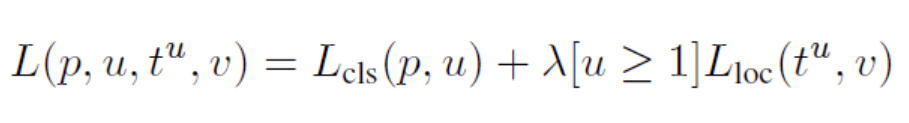

```
보통 기존 Loss에 새로운 Loss를 추가할 때에는 위 식처럼 덧셈으로 연결한 뒤, 새로운 Loss의 영향력을 조절하기 위해 가중치 λ를 붙여준다

Lcls는 따로 SVM을 학습시키지 않고 Classification을 하기 위한 Softmax 함수이며, Lloc는 Localization을 위한 L1 Loss 함수이다 
λ는 1로 고정시켰고, [u≥1]은 'Classification 결과가 Background (u=0)이면 Lloc를 죽이고, 그렇지 않으면 살린다'는 의미이다 
Bounding Box를 치고자 하는 대상은 Background가 아닌 Object이기 때문이다
R-CNN과 SPPNet에서 사용한 L2 대신 L1을 사용한 이유는 덜 민감한 함수이기 때문에 Fine Tuning을 사용하기 쉬워진다 
```

In [ ]:
import pandas as pd 
import tensorflow as tf 

In [ ]:
air = pd.read_csv('dataset/annotations/airplane.csv', header=None, names=['filename','x1','y1','x2','y2','class'])
face = pd.read_csv('dataset/annotations/face.csv', header=None, names=['filename','x1','y1','x2','y2','class'])
motorcycle = pd.read_csv('dataset/annotations/motorcycle.csv', header=None, names=['filename','x1','y1','x2','y2','class'])
air.filename = air.filename.map(lambda x : 'airplane/'+x)
face.filename = face.filename.map(lambda x : 'face/'+x)
motorcycle.filename = motorcycle.filename.map(lambda x : 'motorcycle/'+x)
data = pd.concat([air, face, motorcycle], ignore_index=True)

In [ ]:
data = pd.concat([data, pd.get_dummies(data['class'])], axis=1)
data.drop(columns='class',inplace=True)

In [ ]:
data.columns[1:]

Index(['x1', 'y1', 'x2', 'y2', 'airplane', 'face', 'motorcycle'], dtype='object')

In [ ]:
dig = tf.keras.preprocessing.image.ImageDataGenerator() # dataframe을 바로 불러올 수 있기 때문에 imagedatagenerator를 사용한다
dig = dig.flow_from_dataframe(data, 'dataset/images/', class_mode='raw', y_col=data.columns[1:], target_size=(224,224))

Found 2033 validated image filenames.


In [ ]:
def flow(x):
  while True:
    (X,y) = next(x)
    yield X, (y[:,:4],y[:,4:]) # X는 그대로, y는 4개, 3개로 분리 

In [ ]:
dfg = tf.data.Dataset.from_generator(lambda : flow(dig), output_shapes=(((None,224,224,3)), ((None,4), (None,3))),
                                                  output_types=((tf.float32), (tf.float32, tf.float32)))

In [ ]:
next(iter(dfg))[1][0] # y값 (4개)

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[113.,   9., 286., 239.],
       [ 61.,  47., 210., 141.],
       [ 41.,  22., 225., 134.],
       [ 39.,  32., 226., 149.],
       [ 53.,  29., 349., 135.],
       [ 49.,  28., 346., 116.],
       [ 53.,  63., 335., 138.],
       [ 32.,  16., 230., 113.],
       [121.,  34., 314., 302.],
       [ 32.,  25., 228., 164.],
       [ 37.,  22., 233., 140.],
       [ 34.,  42., 230., 133.],
       [ 35.,  16., 230., 112.],
       [ 75.,  25., 259., 283.],
       [ 46.,  37., 342., 140.],
       [180.,  23., 361., 276.],
       [ 38.,  25., 227., 128.],
       [ 38.,  25., 220., 155.],
       [ 44.,  41., 221., 154.],
       [ 42.,  52., 226., 162.],
       [ 61.,  24., 346., 148.],
       [ 62.,  16., 270., 277.],
       [ 31.,  19., 233., 135.],
       [ 49.,  30., 349., 137.],
       [ 65.,  42., 345., 158.],
       [162.,  47., 414., 302.],
       [ 54.,  30., 345., 130.],
       [ 48.,  31., 350., 112.],
       [ 38.,  24., 224., 1

In [ ]:
next(iter(dfg))[1][1] # y값 (3개)

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3))
vgg.trainable = False 

input_ = tf.keras.Input((224,224,3))
preprocess = tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x))(input_)
x = vgg(preprocess)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

box = tf.keras.layers.Dense(64, activation='relu')(x)
box = tf.keras.layers.Dense(4, name='box',activation='relu')(box)

target = tf.keras.layers.Dense(64, activation='relu')(x)
target = tf.keras.layers.Dense(3, name='target',activation='softmax')(target)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model=tf.keras.models.Model(input_, [box,target])

In [ ]:
loss = {
    'box': tf.keras.losses.MeanAbsoluteError(),
    'target': tf.keras.losses.CategoricalCrossentropy()
}

In [ ]:
model.compile(loss=loss)

In [ ]:
model.fit(dfg, epochs=20, steps_per_epoch=10) # 한 epoch당 10번 업데이트 

Epoch 1/20
10/10 [==============================] - 199s 16s/step - loss: 90.5833 - box_loss: 80.8374 - target_loss: 9.7459
Epoch 2/20
10/10 [==============================] - 158s 16s/step - loss: 38.9525 - box_loss: 38.9085 - target_loss: 0.0441
Epoch 3/20
10/10 [==============================] - 156s 16s/step - loss: 32.4575 - box_loss: 32.4469 - target_loss: 0.0106
Epoch 4/20
10/10 [==============================] - 155s 16s/step - loss: 28.6964 - box_loss: 28.6949 - target_loss: 0.0014
Epoch 5/20
10/10 [==============================] - 153s 15s/step - loss: 28.4143 - box_loss: 28.4143 - target_loss: 6.0349e-08
Epoch 6/20
10/10 [==============================] - 158s 16s/step - loss: 27.1531 - box_loss: 27.1531 - target_loss: 2.0451e-07
Epoch 7/20
10/10 [==============================] - 62s 5s/step - loss: 22.2554 - box_loss: 22.2548 - target_loss: 6.0339e-04
Epoch 8/20
10/10 [==============================] - 3s 350ms/step - loss: 27.1756 - box_loss: 27.1756 - target_loss: 1.862

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    lambda[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
______________________________________________________________________________________________

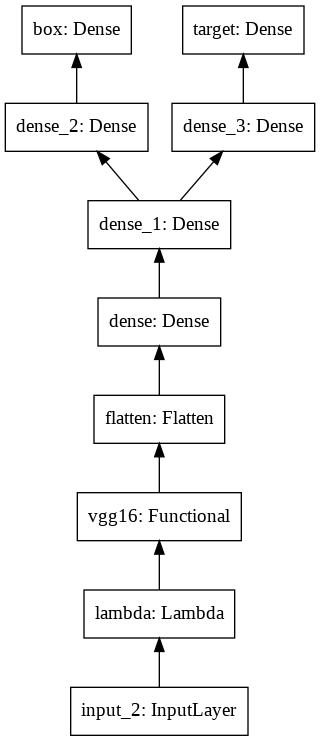

In [ ]:
tf.keras.utils.plot_model(model, rankdir='BT')

In [ ]:
history = model.fit(dfg, epochs=20, steps_per_epoch=20)

Epoch 1/20
20/20 [==============================] - 7s 352ms/step - loss: 17.1495 - box_loss: 17.1495 - target_loss: 8.9183e-06
Epoch 2/20
20/20 [==============================] - 7s 349ms/step - loss: 16.8312 - box_loss: 16.8311 - target_loss: 1.7778e-05
Epoch 3/20
20/20 [==============================] - 7s 338ms/step - loss: 16.1163 - box_loss: 16.1148 - target_loss: 0.0015
Epoch 4/20
20/20 [==============================] - 7s 346ms/step - loss: 16.0480 - box_loss: 16.0480 - target_loss: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 7s 349ms/step - loss: 16.7372 - box_loss: 16.7371 - target_loss: 1.0930e-04
Epoch 6/20
20/20 [==============================] - 7s 344ms/step - loss: 15.5043 - box_loss: 15.4865 - target_loss: 0.0177
Epoch 7/20
20/20 [==============================] - 7s 347ms/step - loss: 14.6377 - box_loss: 14.6377 - target_loss: 9.2198e-08
Epoch 8/20
20/20 [==============================] - 7s 343ms/step - loss: 14.4987 - box_loss: 14.4818 - target_l

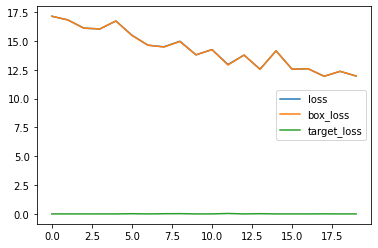

In [ ]:
pd.DataFrame(history.history).plot.line()

In [ ]:
im = tf.keras.preprocessing.image.load_img('dataset/images/airplane/image_0001.jpg')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpt

In [ ]:
bim = np.array(im.resize((224,224,)))[tf.newaxis]

In [ ]:
model(bim)

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 42.0325  ,  28.545605, 291.0303  , 110.72619 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.0000000e+00, 1.5445283e-31, 0.0000000e+00]], dtype=float32)>]

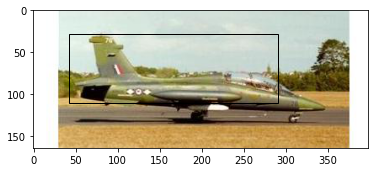

In [ ]:
fig, ax = plt.subplots(1,1)
ax.imshow(im)
pt = mpt.Rectangle((42.0325, 28.545605),291.0303-42.0325,110.72619-28.545605,fill=False)
ax.add_patch(pt)

In [ ]:
!pip install -U tensorflow-hub

### 모델 가져다 쓰는 3가지 

```python
1. tf.keras.applications
2. tensorflow hub 
3. model garden 
```

In [ ]:
import tensorflow_hub as hub # 공개된 모델을 사용할 수 있는 Package

In [ ]:
model = tf.keras.models.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4', trainable=True, 
                   input_shape=(224,224,3))
])
# 주소에 classification가 있으면 classification전용이고 build하지 않아도 모델 안에 넣을 수 있다 (일반적으로) / 뒤에 있는 번호는 버전 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 3,506,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model = tf.keras.models.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', trainable=True,
                   input_shape=(224,224,3))
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
mv2 = tf.keras.applications.MobileNetV2(include_top=True)

14548992/14536120 [==============================] - 1s 0us/step


In [ ]:
mv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________